In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

# Load Dataset

In [2]:
x_train = np.load('data/Eye blink/x_train.npy').astype(np.float32)
y_train = np.load('data/Eye blink/y_train.npy').astype(np.float32)
x_val = np.load('data/Eye blink/x_val.npy').astype(np.float32)
y_val = np.load('data/Eye blink/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


# Preview

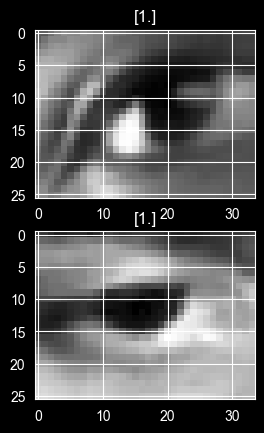

In [3]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[4]))
plt.imshow(x_val[4].reshape((26, 34)), cmap='gray')

# Data Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

# Build Model

In [5]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 34, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 17, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856 

# Train

In [7]:


model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/50


C:\Users\Windows\AppData\Local\Temp\ipykernel_11780\892079145.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


81/81 [==============================] - ETA: 0s - loss: 0.0036 - acc: 0.9981
Epoch 1: val_acc improved from -inf to 0.99653, saving model to models.h5
81/81 [==============================] - 5s 55ms/step - loss: 0.0036 - acc: 0.9981 - val_loss: 0.0059 - val_acc: 0.9965 - lr: 1.0000e-05
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 0.0041 - acc: 0.9988
Epoch 2: val_acc did not improve from 0.99653
81/81 [==============================] - 5s 65ms/step - loss: 0.0041 - acc: 0.9988 - val_loss: 0.0063 - val_acc: 0.9965 - lr: 1.0000e-05
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 0.0042 - acc: 0.9981
Epoch 3: val_acc did not improve from 0.99653
81/81 [==============================] - 5s 66ms/step - loss: 0.0042 - acc: 0.9981 - val_loss: 0.0063 - val_acc: 0.9965 - lr: 1.0000e-05
Epoch 4/50
81/81 [==============================] - ETA: 0s - loss: 0.0044 - acc: 0.9988
Epoch 4: val_acc did not improve from 0.99653
81/81 [=========================

# Confusion Matrix

9/9 [==============================] - 1s 15ms/step
test acc: 0.9965277777777778


<Axes: >

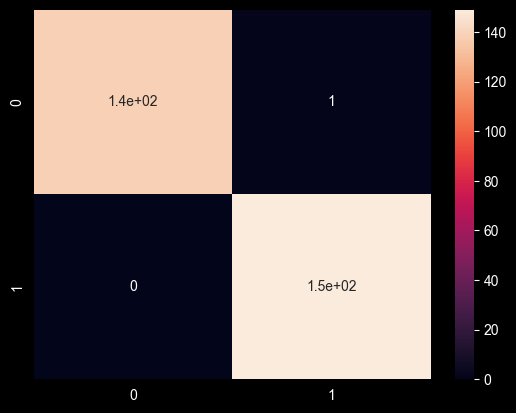

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/model.h5' )

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

# Distribution of Prediction

C:\Users\Windows\AppData\Local\Temp\ipykernel_11780\3214102087.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_pred, kde=False)


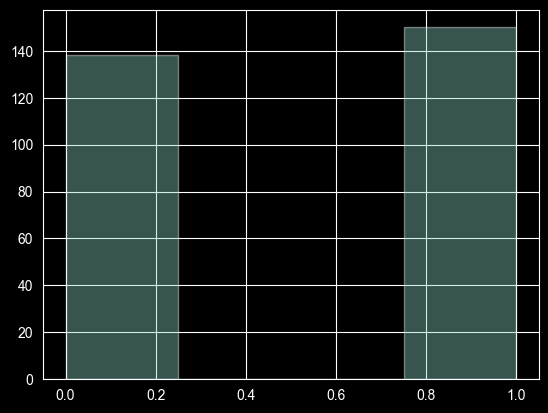

In [10]:
ax = sns.distplot(y_pred, kde=False)